<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Продвинутый поток. Весна 2021</b></h3>

Это домашнее задание будет посвящено полноценному решению задачи машинного обучения.

# Первая часть. Исследование

In [1]:
from sklearn.metrics import roc_auc_score, roc_curve
import pandas as pd
import numpy as npz
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

import warnings
warnings.filterwarnings('ignore')
from sklearn import set_config 
set_config(display='diagram')

In [2]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn import pipeline
from sklearn import preprocessing
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imb_make_pipeline

In [3]:
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

## Функции

In [4]:
def cv_curve(param_name, mean_test, std_test, mean_train, std_train, param_val, x_type, param_scale="log"):
    #try:
    #    param_val.sort()
    #except:
    #    pass
    lower_b_tt = mean_test - 2*std_test
    upper_b_tt= mean_test + 2*std_test
    
    lower_b_tn = mean_train - 2*std_train
    upper_b_tn = mean_train + 2*std_train
    
    f = plt.figure(figsize=(13,5))
    plt.title('choose ' + param_name)
    
    if x_type == 'O':
        plt.plot(range(len(param_val)), mean_test, label='test mean values of score', color='r', lw=3)
        plt.plot(range(len(param_val)), lower_b_tt, label='test lower bound', color='b', lw=2, linestyle='dashed')
        plt.plot(range(len(param_val)), upper_b_tt, label='test upper bound', color='b', lw=2, linestyle='dashed')
        plt.xticks(range(len(param_val)), param_val)

        plt.plot(range(len(param_val)), mean_train, label='train mean values of score', color='gray', lw=1)
        plt.plot(range(len(param_val)), lower_b_tn, label='train lower bound', color='gray', lw=1, linestyle='dashed')
        plt.plot(range(len(param_val)), upper_b_tn, label='train upper bound', color='gray', lw=1, linestyle='dashed')
        plt.xticks(range(len(param_val)), param_val)
    else:
        if param_scale =='log':
            plt.xscale('log')
        plt.plot(param_val, mean_test, label='test mean values of score', color='r', lw=3)
        plt.plot(param_val, lower_b_t, label='lower bound', color='b', lw=2, linestyle='dashed')
        plt.plot(param_val, upper_b_t, label='upper bound', color='b', lw=2, linestyle='dashed')
    legend_box = plt.legend(framealpha=1).get_frame()
    legend_box.set_facecolor('white')
    legend_box.set_edgecolor('red')
    plt.xlabel('parameter')
    plt.ylabel('roc_auc')
    plt.show()

In [5]:
def func_roc_auc(proba, y):
    sns.set(style="whitegrid", palette='Dark2')
    
    auc = roc_auc_score(np.array(y), np.transpose(proba)[1])
    print(f'Лучшее качество auc_best_estimator: {auc:.3}')
    
    fpr, tpr, _ = roc_curve(y, proba[:,1])
    
    f = plt.figure()
    plt.plot(fpr, tpr, label = 'best_estimator')
    plt.plot([0, 1], [0, 1], '--', color = 'grey', label = 'random')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc = "lower right")
    plt.show()

In [6]:
def matthews_cc(contingency_table):
    
    a_1 = contingency_table.iloc[0,0]
    b_2 = contingency_table.iloc[0,1]
    c_3 = contingency_table.iloc[1,0]
    d_4 = contingency_table.iloc[1,1]
    n = contingency_table.sum().sum()
    
    if n <= 40:
        return print('not enough observations')    
    
    con_1 = ((a_1 + c_3) * (a_1 + b_2)) / n
    con_2 = ((a_1 + c_3) * (c_3 + d_4)) / n
    con_3 = ((b_2 + d_4) * (a_1 + b_2)) / n
    con_4 = ((b_2 + d_4) * (c_3 + d_4)) / n
    
    if (con_1 or con_2 or con_3 or con_4) < 5:
        return print('wrong density of distribution')
    
    cont = stats.chi2_contingency(contingency_table)
    # считаем кооэффициент корреляции
    MCC = (a_1 * d_4 - b_2 * c_3) / (np.sqrt((a_1 + b_2) * (a_1 + c_3) * (b_2 + d_4) * (c_3 + d_4)))
    # считаем статистику
    Chi_square = n * (MCC ** 2) 
    # считаем p-value для коэффициента
    p_value = 1 - stats.chi2.cdf(Chi_square, df = 1)
    #'cont =', cont, '\n',
    return print( 'MCC =', MCC, '\n', 'Chi_square =', Chi_square, '\n', 'p_value =', p_value)

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return print(f"Коэф-т Крамера: {np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))}")

## Загрузка данных (2 балла)

1) Посмотрите на случайные строчки. 

2) Посмотрите, есть ли в датасете незаполненные значения (nan'ы) с помощью data.isna() или data.info() и, если нужно, замените их на что-то. Будет хорошо, если вы построите табличку с количеством nan в каждой колонке.

In [5]:
data = pd.read_csv('./train.csv')

num_cols = ['ClientPeriod','MonthlySpending', 'TotalSpent']

cat_cols = ['Sex','IsSeniorCitizen','HasPartner','HasChild','HasPhoneService','HasMultiplePhoneNumbers',
            'HasInternetService','HasOnlineSecurityService','HasOnlineBackup','HasDeviceProtection',
            'HasTechSupportAccess','HasOnlineTV','HasMovieSubscription','HasContractPhone','IsBillingPaperless',
            'PaymentMethod']

feature_cols = num_cols + cat_cols
target_col = 'Churn'

# Переводим TotalSpent в формат флоат. 
# Заполняем для новых пользователей колонку TotalSpent 0
data.loc[data["ClientPeriod"] == 0, ["TotalSpent"]] = 0
data.loc[:, "TotalSpent"] = data.loc[:, "TotalSpent"].astype(float)

In [6]:
data.sample(5)

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
4452,29,20.65,654.85,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,Yes,Mailed check,0
4394,4,63.75,226.20,Male,0,No,No,Yes,No,DSL,No,Yes,No,Yes,Yes,No,Month-to-month,Yes,Bank transfer (automatic),0
3520,38,70.15,2497.35,Male,1,No,No,Yes,No,DSL,No,Yes,Yes,Yes,Yes,No,One year,Yes,Credit card (automatic),1
1808,53,19.85,1049.60,Female,0,No,No,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),0
846,8,94.00,773.65,Male,0,No,No,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,No,Month-to-month,Yes,Electronic check,1


In [8]:
data.isnull().sum()

ClientPeriod                0
MonthlySpending             0
TotalSpent                  0
Sex                         0
IsSeniorCitizen             0
HasPartner                  0
HasChild                    0
HasPhoneService             0
HasMultiplePhoneNumbers     0
HasInternetService          0
HasOnlineSecurityService    0
HasOnlineBackup             0
HasDeviceProtection         0
HasTechSupportAccess        0
HasOnlineTV                 0
HasMovieSubscription        0
HasContractPhone            0
IsBillingPaperless          0
PaymentMethod               0
Churn                       0
dtype: int64

## Анализ данных (3 балла)

In [9]:
sns.set(style="whitegrid", palette='Dark2')

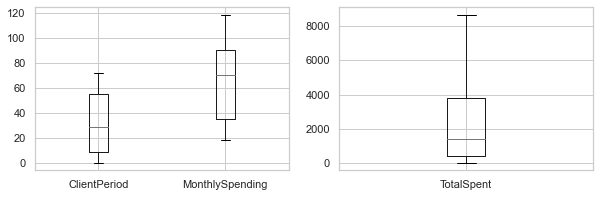

In [10]:
# Выбросы в численных признаках отсутствуют
f, axes = plt.subplots(1,2, figsize=(10,3))
data.loc[:, num_cols[0:2]].boxplot(ax=axes[0])
data.loc[:, num_cols[2:]].boxplot(ax=axes[1])
plt.show()

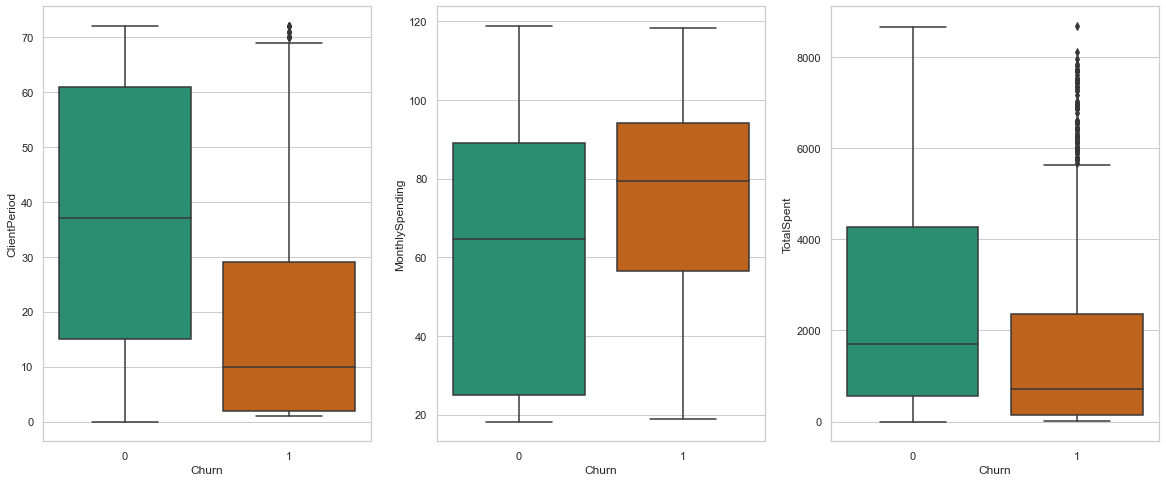

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 8))

for idx, feat in enumerate(num_cols):
    sns.boxplot(x='Churn', y=feat, data=data, ax=axes[idx])
    axes[idx].set_xlabel('Churn')
    axes[idx].set_ylabel(feat);
    
# На первый взгляд кажется, что 
# Во-первых, вероятность уйти выше у новых пользователей
# Во-вторых, пользователи, склонные к отттоку, в среднем на ежемесячной основе платят больше 
# Ну и, следовательно, учитывая тот факт, что новые пользователя склонны утекать, 
# вполне логично, что в среднем у тех, кто ушел, общие расходы ниже тех, кто остался

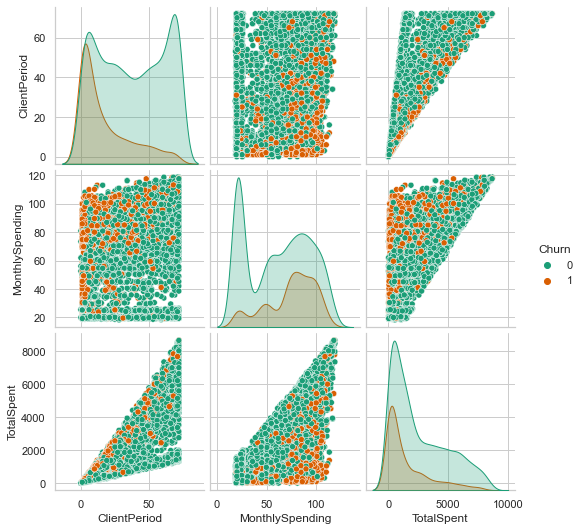

In [12]:
# Посмотрим на распределение данных
sns.pairplot(data.loc[:, ['ClientPeriod', 'MonthlySpending', 'TotalSpent', "Churn"]], hue="Churn")

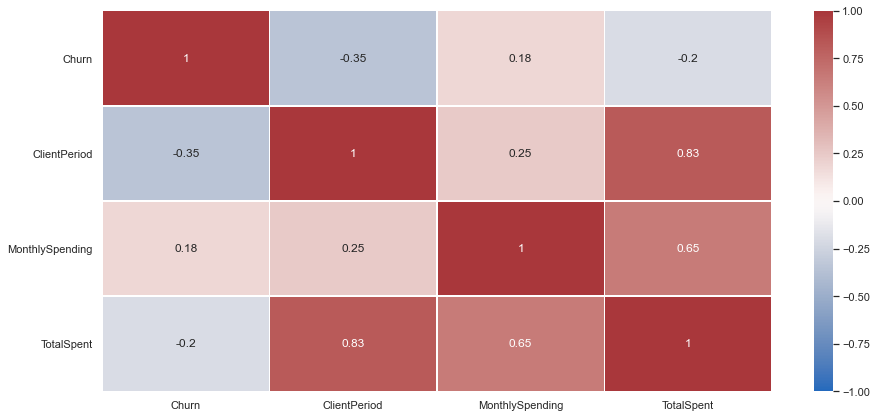

In [13]:
# Проверим наличие линейных зависимостей в данных
corr_matrix = data.loc[:, ['Churn']+num_cols].corr()
f, ax = plt.subplots(figsize=(15,7))
sns.heatmap(corr_matrix, vmin=-1, vmax=1, linewidths=0.5, cmap = 'vlag', annot=True)
plt.yticks(rotation = 0)
plt.show()

# Как и ожидалось наблюдается сильная линейная зависимость у показателей ClientPeriod и TotalSpent 

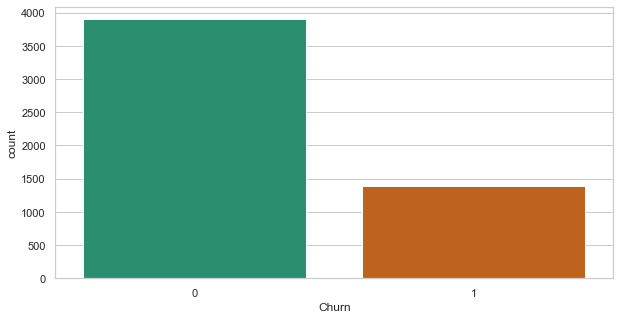

In [14]:
# Заметим, что классы слегка несбалансированы
# Ради тренировки будем балансировать их с помощью SMOTE в LR
fig = plt.figure(figsize=(10,5))
sns.countplot(x="Churn", data=data)
plt.show()

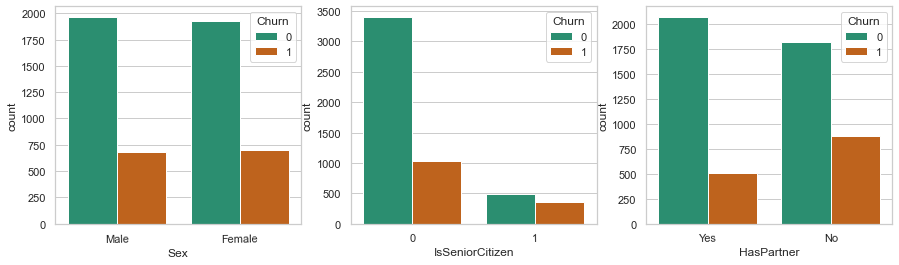

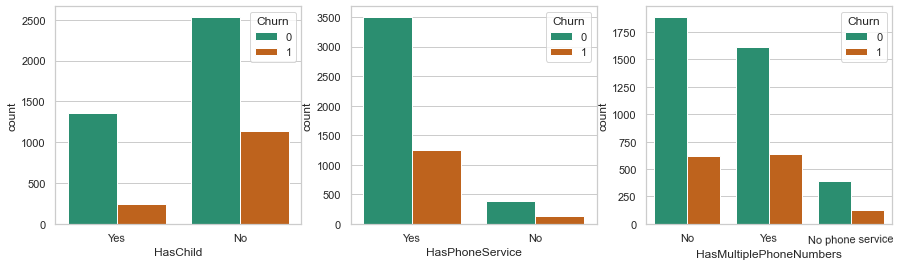

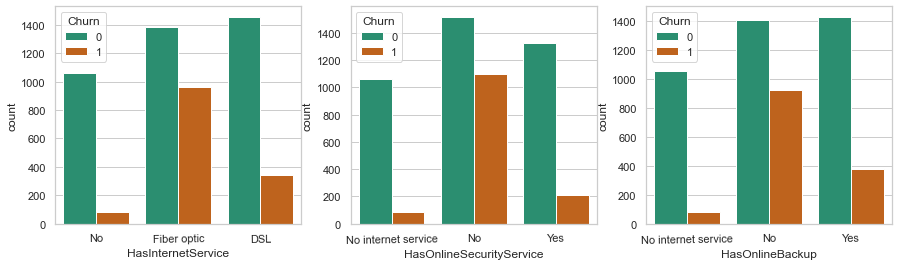

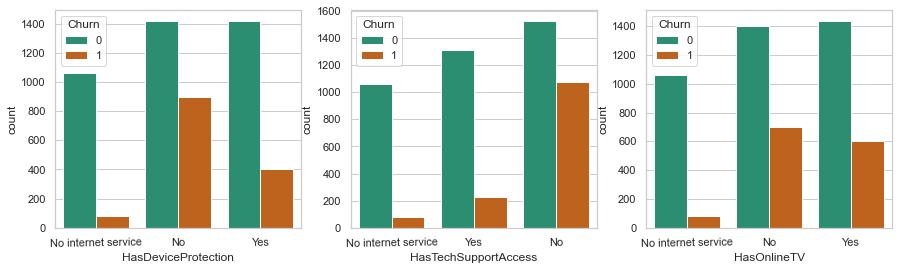

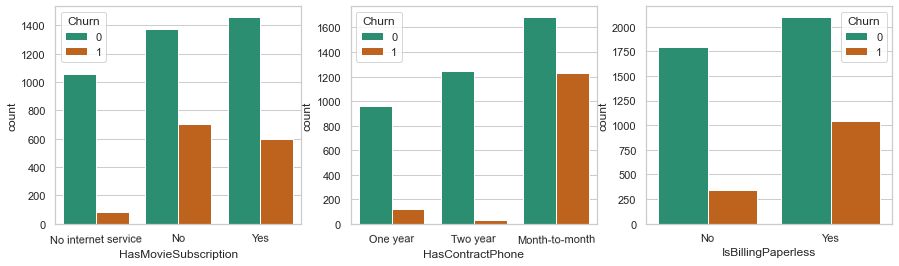

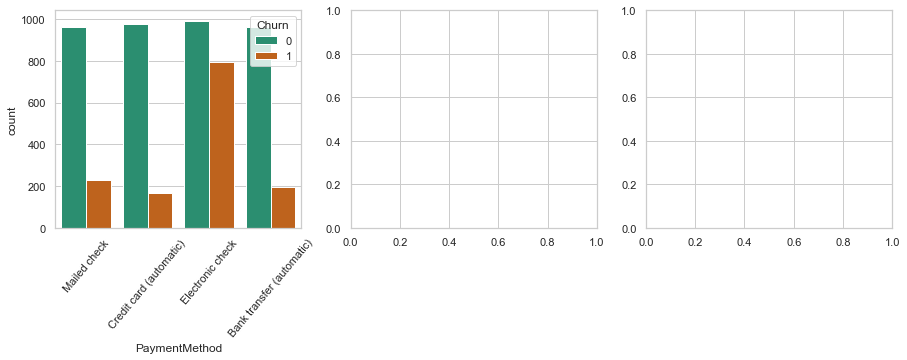

In [61]:
# Распрделение категориальных фич
for k in range(0,16,3):
    fig, axes = plt.subplots(1, 3, figsize=(15,4))
    for i, column in enumerate(cat_cols[k:k+3]):
        axes = axes.ravel()
        sns.countplot(x=column, hue='Churn', data=data, ax=axes[i])
        if k != 15:
            axes[i].tick_params(axis='x', labelrotation=1)
        else:
            axes[i].tick_params(axis='x', labelrotation=50)
    plt.show()

In [20]:
# Проверим гипотезы о наличии связи между категориальными колонками и оттоком
from scipy import stats
for column in cat_cols:
    cross = pd.crosstab(data.Churn, data[column])
    print(f"Корреляция Churn c {column}")
    if data[column].value_counts().index.shape[0] == 2:
        matthews_cc(cross)
    else:
        cramers_v(data.Churn, data[column])
    print("\n")
    
# Sex и HasPhoneService не связаны с Churn, в логрегрессии их использовать смысла нет

Корреляция Churn c Sex
MCC = -0.008325255833283127 
 Chi_square = 0.36609481093054497 
 p_value = 0.5451406640779225


Корреляция Churn c IsSeniorCitizen
MCC = 0.1568716643176428 
 Chi_square = 129.98325410548802 
 p_value = 0.0


Корреляция Churn c HasPartner
MCC = -0.1483470420003425 
 Chi_square = 116.24015460466778 
 p_value = 0.0


Корреляция Churn c HasChild
MCC = -0.16360945686879239 
 Chi_square = 141.38886321879232 
 p_value = 0.0


Корреляция Churn c HasPhoneService
MCC = 0.010848767781707227 
 Chi_square = 0.621669016898601 
 p_value = 0.430427744284986


Корреляция Churn c HasMultiplePhoneNumbers
Коэф-т Крамера: 0.03446284955963664


Корреляция Churn c HasInternetService
Коэф-т Крамера: 0.3153113103383512


Корреляция Churn c HasOnlineSecurityService
Коэф-т Крамера: 0.35593323065800675


Корреляция Churn c HasOnlineBackup
Коэф-т Крамера: 0.29412652349434354


Корреляция Churn c HasDeviceProtection
Коэф-т Крамера: 0.2817379871157493


Корреляция Churn c HasTechSupportAccess


## Применение линейных моделей (3 балла)


In [7]:
# Загрзим еще раз данные, чтобы каждый блок можно было запускать отдельно
data = pd.read_csv('./train.csv')

# Переводим TotalSpent в формат флоат. 
# Заполняем для новых пользователей колонку TotalSpent 0
data.loc[data["ClientPeriod"] == 0, ["TotalSpent"]] = 0
data.loc[:, "TotalSpent"] = data.loc[:, "TotalSpent"].astype(float)

# Распределим названия колонок
binary_data_columns_lr = ['IsSeniorCitizen', 'HasPartner', 'HasChild', 'IsBillingPaperless']
numeric_data_columns_lr =  ['ClientPeriod','MonthlySpending']
categorical_data_columns_lr = ['HasMultiplePhoneNumbers','HasInternetService','HasOnlineSecurityService',
                               'HasOnlineBackup','HasDeviceProtection','HasTechSupportAccess','HasOnlineTV',
                               'HasMovieSubscription','HasContractPhone','PaymentMethod']

# Удалим неинформативные фичи, выявленные в ходе анализа
x_train_lr = data.drop(columns=["Sex","HasPhoneService", "TotalSpent", "Churn"])
y_train = data.loc[:, ["Churn"]]

In [8]:
# Определяем ЛогРег
regressor = LogisticRegression(random_state=42, C=0.01, penalty="l2", solver="lbfgs")

# Определим SMOTE
sm = SMOTE(random_state=123, k_neighbors=4)

# Определяем Пайплайн для GridSearchCV.
estimator_lr = imb_make_pipeline(steps = [       
    ('feature_processing', pipeline.FeatureUnion(transformer_list = [        
            #binary
            ('binary_variables_processing', pipeline.Pipeline(steps = [
                ('selecting', preprocessing.FunctionTransformer(lambda dataset: dataset.loc[:, binary_data_columns_lr])),
                ('labelencoder', preprocessing.OrdinalEncoder())])),
                    
            #numeric
            ('numeric_variables_processing', pipeline.Pipeline(steps = [
                ('selecting', preprocessing.FunctionTransformer(lambda dataset: dataset.loc[:, numeric_data_columns_lr])),
                ('scaling', StandardScaler())])),            
        
            #categorical
            ('categorical_variables_processing', pipeline.Pipeline(steps = [
                ('selecting', preprocessing.FunctionTransformer(lambda dataset: dataset.loc[:, categorical_data_columns_lr])),
                ('label', preprocessing.OrdinalEncoder()),
                ('hot_encoding', preprocessing.OneHotEncoder())])),
        ])),
    ('SMOTE', sm),
    ('model_fitting', regressor), 
    ]
)

In [9]:
# Определяем сеть поиска
param_grid = {
    'feature_processing__numeric_variables_processing__scaling': [StandardScaler(), RobustScaler(), MinMaxScaler()],
    'model_fitting__penalty': ["l1", "l2"],
    'model_fitting__C': [0.001, 0.01, 0.1, 1, 2],
    'model_fitting__solver': ['liblinear','lbfgs','saga']
}

# Определяем Поиск по сети
clf = GridSearchCV(estimator_lr, 
                   param_grid=param_grid, 
                   scoring='roc_auc', 
                   cv = 4, 
                   return_train_score=True 
                  )

# Обучаем clf
clf.fit(x_train_lr, y_train)

GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('feature_processing',
                                        FeatureUnion(transformer_list=[('binary_variables_processing',
                                                                        Pipeline(steps=[('selecting',
                                                                                         FunctionTransformer(func=<function <lambda> at 0x000001516AF3AAF0>)),
                                                                                        ('labelencoder',
                                                                                         OrdinalEncoder())])),
                                                                       ('numeric_variables_processing',
                                                                        Pipeline(steps=[('selecting',
                                                                                         FunctionTransformer(func=<fun...
                                       ('model_fitting',
                                        LogisticRegression(C=0.01,
                                                           random_state=42))]),
             param_grid={'feature_processing__numeric_variables_processing__scaling': [StandardScaler(),
                                                                                       RobustScaler(),
                                                                                       MinMaxScaler()],
                         'model_fitting__C': [0.001, 0.01, 0.1, 1, 2],
                         'model_fitting__penalty': ['l1', 'l2'],
                         'model_fitting__solver': ['liblinear', 'lbfgs',
                                                   'saga']},
             return_train_score=True, scoring='roc_auc')

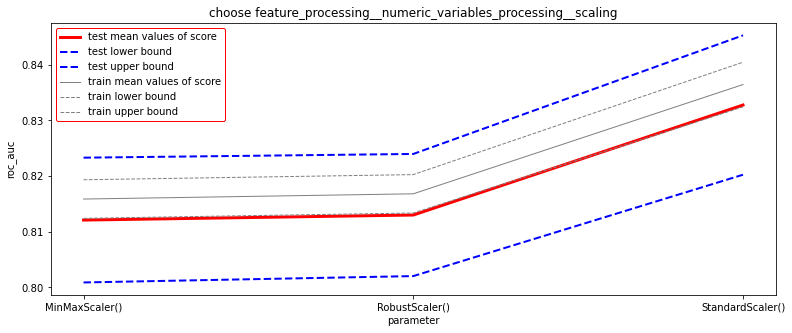

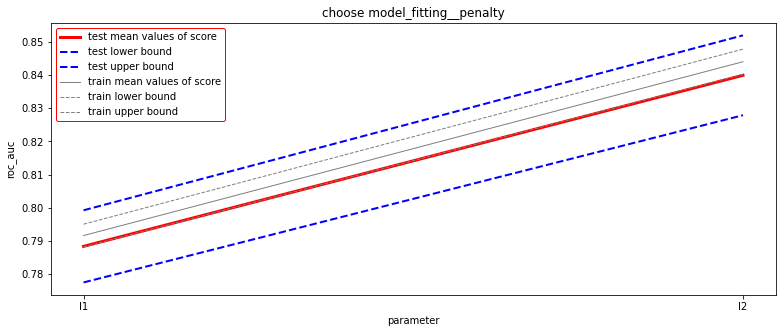

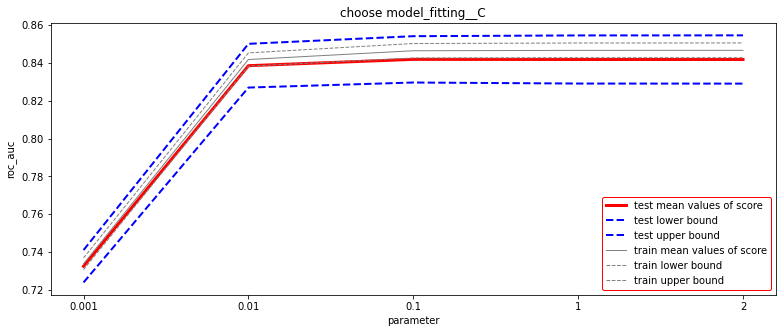

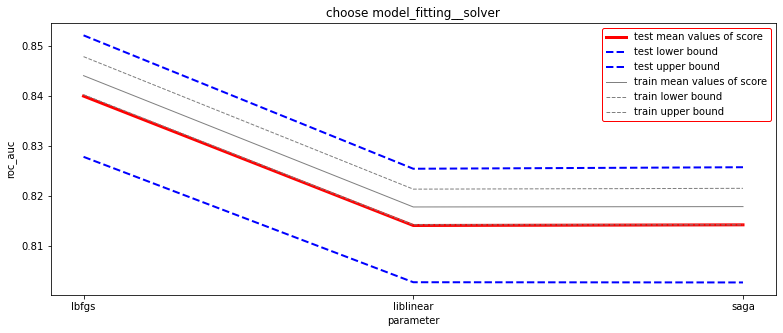

In [11]:
# Рисуем кривые валидации 
rs_df = pd.DataFrame(clf.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
rs_df.drop(columns = ['mean_fit_time', 'std_fit_time', 'mean_score_time','std_score_time', 'params', 
                      'split0_test_score', 'split1_test_score', 'split2_test_score','split3_test_score',
                      'split0_train_score', 'split1_train_score', 
                      'split2_train_score', 'split3_train_score'], inplace=True)
rs_df.dropna(inplace=True)

for element in list(param_grid.keys()):
   
    table = rs_df.loc[:, ["param_"+element, "mean_test_score", "std_test_score", "mean_train_score", "std_train_score"]]
    if table["param_"+element].dtype == "O":
        table["param_"+element] = table["param_"+element].astype(str)
    table.sort_values("param_"+element, inplace=True)
    param_val = table["param_"+element].drop_duplicates().values
    mean_test, std_test, mean_train, std_train = table.groupby("param_"+element).mean().values.T
    cv_curve(param_name = element, mean_test=mean_test, std_test=std_test,
             mean_train=mean_train, std_train=std_train, param_val=param_val, x_type = param_val.dtype)

#### Итог по качеству:

In [12]:
# Лучшее параметры
clf.best_params_

{'feature_processing__numeric_variables_processing__scaling': MinMaxScaler(),
 'model_fitting__C': 0.1,
 'model_fitting__penalty': 'l1',
 'model_fitting__solver': 'saga'}

Лучшее качество auc_best_estimator: 0.846


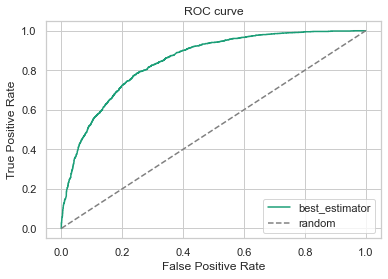

In [13]:
func_roc_auc(proba=clf.best_estimator_.predict_proba(x_train_lr), y=y_train)

## Применение градиентного бустинга (2 балла)

Если вы хотите получить баллы за точный ответ, то стоит попробовать градиентный бустинг. Часто градиентный бустинг с дефолтными параметрами даст вам 80% результата за 0% усилий.

Мы будем использовать catboost, поэтому нам не надо кодировать категориальные признаки. catboost сделает это сам (в .fit() надо передать cat_features=cat_cols). А численные признаки нормировать для моделей, основанных на деревьях не нужно.

1) Разделите выборку на train/valid. Протестируйте catboost cо стандартными параметрами.

2) Протестируйте разные занчения параметроа количества деревьев и learning_rate'а и выберите лучшую по метрике ROC-AUC комбинацию. 

(Дополнительно) Есть некоторые сложности с тем, чтобы использовать CatBoostClassifier вместе с GridSearchCV, поэтому мы не просим использовать кроссвалидацию. Но можете попробовать)

In [53]:
data = pd.read_csv('./train.csv')

# Переводим TotalSpent в формат флоат. 
# Заполняем для новых пользователей колонку TotalSpent 0
data.loc[data["ClientPeriod"] == 0, ["TotalSpent"]] = 0
data.loc[:, "TotalSpent"] = data.loc[:, "TotalSpent"].astype(float)

# Распределим названия колонок
binary_data_columns_cbc = ["Sex", 'IsSeniorCitizen', 'HasPartner', 'HasChild', 'IsBillingPaperless']
numeric_data_columns_cbc =  ['ClientPeriod','MonthlySpending', 'TotalSpent']
categorical_data_columns_cbc = ['HasMultiplePhoneNumbers','HasInternetService','HasOnlineSecurityService',
                               'HasOnlineBackup','HasDeviceProtection','HasTechSupportAccess','HasOnlineTV',
                               'HasMovieSubscription','HasContractPhone','PaymentMethod']

# Удалим неинформативные фичи, выявленные в ходе анализа
x_train_cbc = data.drop(columns=["Churn"])
x_train_cbc = x_train_cbc.loc[:, binary_data_columns_cbc+categorical_data_columns_cbc+numeric_data_columns_cbc]
y_train = data.loc[:, ["Churn"]]

In [27]:
X_train_sp, X_test_sp, y_train_sp, y_test_sp = train_test_split(x_train_cbc, y_train,
                                                                test_size=0.2, random_state=42, stratify=y_train)

In [8]:
# Используем гридсерч, но не встроенный, а из sklearn, так как добавим полиномы для числовых фич в пайплайн
# Так как используем гридсерч, делить на трейн/тест смысла нет

In [14]:
model = CatBoostClassifier(cat_features=np.arange(0,15), task_type="GPU",
                          learning_rate=0.08, depth=5, l2_leaf_reg=5, iterations=90, logging_level="Silent", 
                          auto_class_weights = "SqrtBalanced", loss_function = "Logloss")

# Определяем Пайплайн
estimator_cbc = imb_make_pipeline(steps = [       
    ('feature_processing', pipeline.FeatureUnion(transformer_list = [        
            #binary
            ('binary_variables_processing', pipeline.Pipeline(steps = [
                ('selecting', preprocessing.FunctionTransformer(lambda dataset: dataset.loc[:, binary_data_columns_cbc]))])),
        
            #categorical
            ('categorical_variables_processing', pipeline.Pipeline(steps = [
            ('selecting', preprocessing.FunctionTransformer(lambda dataset: dataset.loc[:, categorical_data_columns_cbc]))])),
        
            #numeric
            ('numeric_variables_processing', pipeline.Pipeline(steps = [
                ('selecting', preprocessing.FunctionTransformer(lambda dataset: dataset.loc[:, numeric_data_columns_cbc])),
                ('poly', preprocessing.PolynomialFeatures(2))])),            
        
        ])),
    ('model_fitting', model), 
    ]
)

In [17]:
grid = {
        'model_fitting__learning_rate' : [0.07, 0.08, 0.09, 0.1],
        'model_fitting__depth'         : [4, 5, 6, 7, 8],
        'model_fitting__l2_leaf_reg'   : [4, 5, 6, 7], 
        'model_fitting__iterations'    : [90, 100, 110, 120], 
        'model_fitting__loss_function' : ["CrossEntropy", "Logloss"],
        'model_fitting__auto_class_weights': ["SqrtBalanced", "Balanced"]
        }

# Определяем Поиск по сети
cbc = GridSearchCV(estimator_cbc, 
                   param_grid=grid, 
                   scoring='roc_auc', 
                   cv=4,
                   return_train_score=True)

# Обучаем estimator
cbc.fit(x_train_cbc, y_train)

GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('feature_processing',
                                        FeatureUnion(transformer_list=[('binary_variables_processing',
                                                                        Pipeline(steps=[('selecting',
                                                                                         FunctionTransformer(func=<function <lambda> at 0x00000223A03B2160>))])),
                                                                       ('categorical_variables_processing',
                                                                        Pipeline(steps=[('selecting',
                                                                                         FunctionTransformer(func=<function <lambda> at 0x000002239FF34...
                                        <catboost.core.CatBoostClassifier object at 0x000002239FCB04C0>)]),
             param_grid={'model_fitting__auto_class_weights': ['SqrtBalanced',
                                                               'Balanced'],
                         'model_fitting__depth': [4, 5, 6, 7, 8],
                         'model_fitting__iterations': [90, 100, 110, 120],
                         'model_fitting__l2_leaf_reg': [4, 5, 6, 7],
                         'model_fitting__learning_rate': [0.07, 0.08, 0.09,
                                                          0.1],
                         'model_fitting__loss_function': ['CrossEntropy',
                                                          'Logloss']},
             return_train_score=True, scoring='roc_auc')

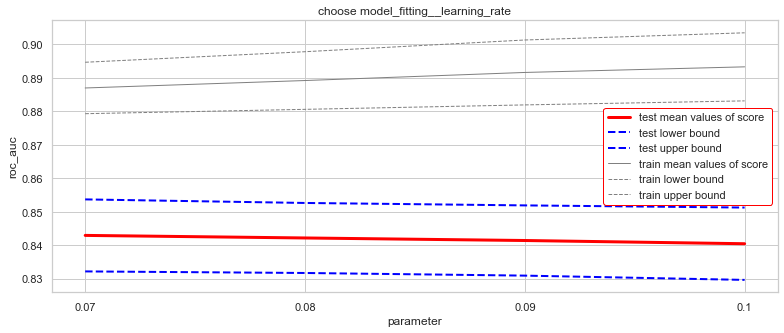

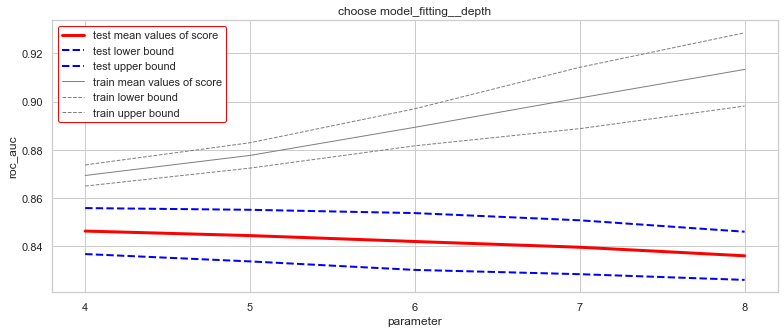

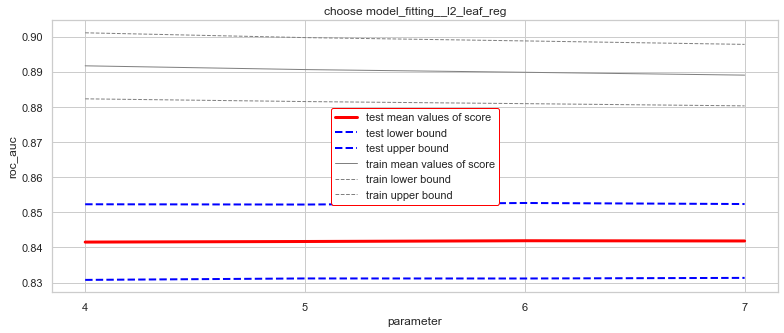

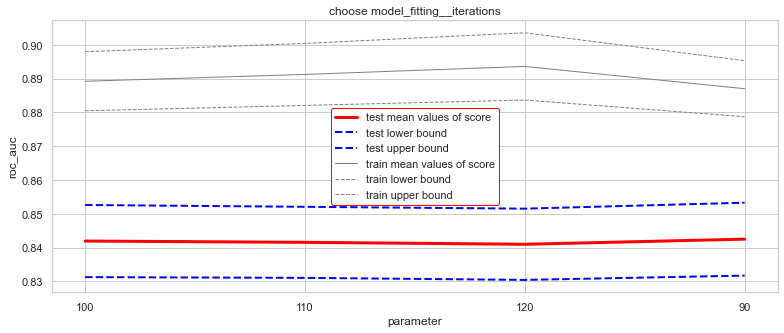

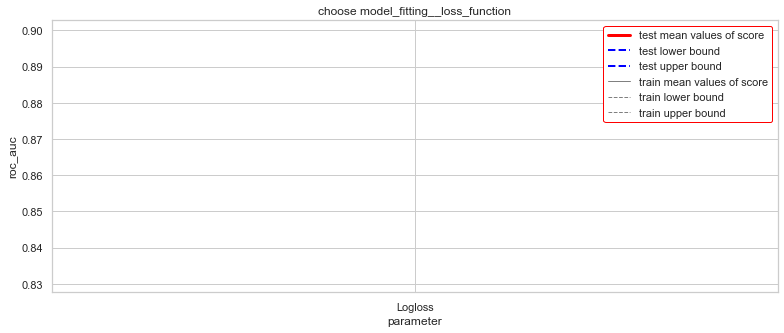

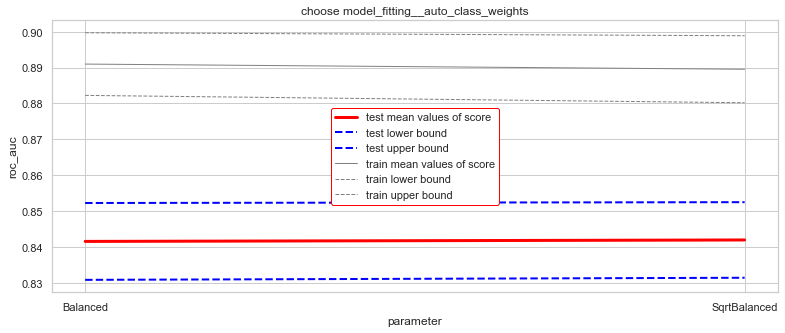

In [22]:
# Рисуем кривые валидации 
rs_df = pd.DataFrame(cbc.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
rs_df.drop(columns = ['mean_fit_time', 'std_fit_time', 'mean_score_time','std_score_time', 'params', 
                      'split0_test_score', 'split1_test_score', 'split2_test_score','split3_test_score',
                      'split0_train_score', 'split1_train_score', 
                      'split2_train_score', 'split3_train_score'], inplace=True)
rs_df.dropna(inplace=True)

for element in list(grid.keys()):
   
    table = rs_df.loc[:, ["param_"+element, "mean_test_score", "std_test_score", "mean_train_score", "std_train_score"]]
    if table["param_"+element].dtype == "O":
        table["param_"+element] = table["param_"+element].astype(str)
    table.sort_values("param_"+element, inplace=True)
    param_val = table["param_"+element].drop_duplicates().values
    mean_test, std_test, mean_train, std_train = table.groupby("param_"+element).mean().values.T
    cv_curve(param_name = element, mean_test=mean_test, std_test=std_test,
             mean_train=mean_train, std_train=std_train, param_val=param_val, x_type = param_val.dtype)

In [20]:
# Лучшее параметры
cbc.best_params_

#{'model_fitting__depth': 5,
# 'model_fitting__iterations': 80,
# 'model_fitting__l2_leaf_reg': 5,
# 'model_fitting__learning_rate': 0.08}

{'model_fitting__auto_class_weights': 'SqrtBalanced',
 'model_fitting__depth': 4,
 'model_fitting__iterations': 90,
 'model_fitting__l2_leaf_reg': 6,
 'model_fitting__learning_rate': 0.09,
 'model_fitting__loss_function': 'Logloss'}

In [91]:
model = CatBoostClassifier(cat_features=np.arange(0,15), task_type="GPU",
                          learning_rate=0.09, depth=4, l2_leaf_reg=1, iterations=120, logging_level="Silent", 
                          auto_class_weights = "Balanced", loss_function = "Logloss")

# Определяем Пайплайн
estimator_cbc = imb_make_pipeline(steps = [       
    ('feature_processing', pipeline.FeatureUnion(transformer_list = [        
            #binary
            ('binary_variables_processing', pipeline.Pipeline(steps = [
                ('selecting', preprocessing.FunctionTransformer(lambda dataset: dataset.loc[:, binary_data_columns_cbc]))])),
        
            #categorical
            ('categorical_variables_processing', pipeline.Pipeline(steps = [
            ('selecting', preprocessing.FunctionTransformer(lambda dataset: dataset.loc[:, categorical_data_columns_cbc]))])),
        
            #numeric
            ('numeric_variables_processing', pipeline.Pipeline(steps = [
                ('selecting', preprocessing.FunctionTransformer(lambda dataset: dataset.loc[:, numeric_data_columns_cbc])),
                ('poly', preprocessing.PolynomialFeatures(4))])),            
        
        ])),
    ('model_fitting', model), 
    ]
)

In [92]:
estimator_cbc.fit(X_train_sp, y_train_sp)

Pipeline(steps=[('feature_processing',
                 FeatureUnion(transformer_list=[('binary_variables_processing',
                                                 Pipeline(steps=[('selecting',
                                                                  FunctionTransformer(func=<function <lambda> at 0x000002233943DD30>))])),
                                                ('categorical_variables_processing',
                                                 Pipeline(steps=[('selecting',
                                                                  FunctionTransformer(func=<function <lambda> at 0x00000223397E7550>))])),
                                                ('numeric_variables_processing',
                                                 Pipeline(steps=[('selecting',
                                                                  FunctionTransformer(func=<function <lambda> at 0x0000022339D34670>)),
                                                                 ('poly',
                                                                  PolynomialFeatures(degree=4))]))])),
                ('model_fitting',
                 <catboost.core.CatBoostClassifier object at 0x00000223395E3BE0>)])

Лучшее качество auc_best_estimator: 0.86


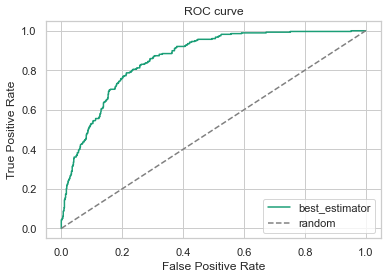

In [93]:
func_roc_auc(proba=estimator_cbc.predict_proba(X_test_sp), y=y_test_sp)
# 0.869

# Стекинг

In [5]:
data = pd.read_csv('./train.csv')

# Переводим TotalSpent в формат флоат. 
# Заполняем для новых пользователей колонку TotalSpent 0
data.loc[data["ClientPeriod"] == 0, ["TotalSpent"]] = 0
data.loc[:, "TotalSpent"] = data.loc[:, "TotalSpent"].astype(float)

In [6]:
X = data.drop(columns=["Churn"])
y = data.loc[:, ["Churn"]]

In [8]:
binary_data_columns = ['IsSeniorCitizen', 'HasPartner', 'HasChild', 'IsBillingPaperless']
numeric_data_columns =  ['ClientPeriod','MonthlySpending', 'TotalSpent']
categorical_data_columns = ['HasMultiplePhoneNumbers','HasInternetService','HasOnlineSecurityService',
                               'HasOnlineBackup','HasDeviceProtection','HasTechSupportAccess','HasOnlineTV',
                               'HasMovieSubscription','HasContractPhone','PaymentMethod']


# Распределим названия колонок
binary_data_columns_lr = ['IsSeniorCitizen', 'HasPartner', 'HasChild', 'IsBillingPaperless']
numeric_data_columns_lr =  ['ClientPeriod','MonthlySpending']
categorical_data_columns_lr = ['HasMultiplePhoneNumbers','HasInternetService','HasOnlineSecurityService',
                               'HasOnlineBackup','HasDeviceProtection','HasTechSupportAccess','HasOnlineTV',
                               'HasMovieSubscription','HasContractPhone','PaymentMethod']

In [9]:
# Определяем ЛогРег
regressor = LogisticRegression(random_state=42, C=0.01, penalty="l2", solver="lbfgs")

# Определим SMOTE
sm = SMOTE(random_state=123, k_neighbors=4)

# Определяем Пайплайн
estimator_lr = imb_make_pipeline(steps = [       
    ('feature_processing', pipeline.FeatureUnion(transformer_list = [        
            #binary
            ('binary_variables_processing', pipeline.Pipeline(steps = [
                ('selecting', preprocessing.FunctionTransformer(lambda dataset: dataset.loc[:, binary_data_columns_lr])),
                ('labelencoder', preprocessing.OrdinalEncoder())])),
                    
            #numeric
            ('numeric_variables_processing', pipeline.Pipeline(steps = [
                ('selecting', preprocessing.FunctionTransformer(lambda dataset: dataset.loc[:, numeric_data_columns_lr])),
                ('scaling', StandardScaler())])),            
        
            #categorical
            ('categorical_variables_processing', pipeline.Pipeline(steps = [
                ('selecting', preprocessing.FunctionTransformer(lambda dataset: dataset.loc[:, categorical_data_columns_lr])),
                ('label', preprocessing.OrdinalEncoder()),
                ('hot_encoding', preprocessing.OneHotEncoder())])),
        ])),
    ('SMOTE', sm),
    ('model_fitting', regressor), 
    ]
)

In [10]:
model = CatBoostClassifier(cat_features=np.arange(0,14), task_type="GPU",
                          learning_rate=0.08, depth=5, l2_leaf_reg=5, iterations=80,
                          logging_level="Silent", auto_class_weights = "SqrtBalanced")

# Определяем Пайплайн
estimator_cbc = imb_make_pipeline(steps = [       
    ('feature_processing', pipeline.FeatureUnion(transformer_list = [        
            #binary
            ('binary_variables_processing', pipeline.Pipeline(steps = [
                ('selecting', preprocessing.FunctionTransformer(lambda dataset: dataset.loc[:, binary_data_columns]))])),
        
            #categorical
            ('categorical_variables_processing', pipeline.Pipeline(steps = [
            ('selecting', preprocessing.FunctionTransformer(lambda dataset: dataset.loc[:, categorical_data_columns]))])),
        
            #numeric
            ('numeric_variables_processing', pipeline.Pipeline(steps = [
                ('selecting', preprocessing.FunctionTransformer(lambda dataset: dataset.loc[:, numeric_data_columns])),
                ('poly', preprocessing.PolynomialFeatures(2))])),            
        
        ])),
    ('model_fitting', model), 
    ]
)

In [11]:
from sklearn.ensemble import StackingClassifier

estimators = [
     ('cbc', estimator_cbc),
     ('lrc', estimator_lr) ]

stckg = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(random_state=42, C=0.03, penalty="l2"))

stckg.fit(X, y)

StackingClassifier(estimators=[('cbc',
                                Pipeline(steps=[('feature_processing',
                                                 FeatureUnion(transformer_list=[('binary_variables_processing',
                                                                                 Pipeline(steps=[('selecting',
                                                                                                  FunctionTransformer(func=<function <lambda> at 0x00000189198070D0>))])),
                                                                                ('categorical_variables_processing',
                                                                                 Pipeline(steps=[('selecting',
                                                                                                  FunctionTransformer(func=<function <lambda> at 0x000...
                                                                                ('categorical_variables_processing',
                                                                                 Pipeline(steps=[('selecting',
                                                                                                  FunctionTransformer(func=<function <lambda> at 0x0000018919807040>)),
                                                                                                 ('label',
                                                                                                  OrdinalEncoder()),
                                                                                                 ('hot_encoding',
                                                                                                  OneHotEncoder())]))])),
                                                ('SMOTE',
                                                 SMOTE(k_neighbors=4,
                                                       random_state=123)),
                                                ('model_fitting',
                                                 LogisticRegression(C=0.01,
                                                                    random_state=42))]))],
                   final_estimator=LogisticRegression(C=0.03, random_state=42))

In [12]:
# Рисуем качество 
proba_stckg = stckg.predict_proba(X)

Лучшее качество auc_best_estimator: 0.86


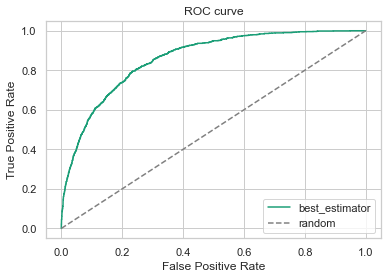

In [13]:
# Ничего хорошего не получилось :D
func_roc_auc(proba=proba_stckg, y=y)

# Предсказания

In [14]:
# Логрег ~0,846
X_test = pd.read_csv('./test.csv')
X_test.loc[X_test["ClientPeriod"] == 0, ["TotalSpent"]] = 0
X_test.loc[:, "TotalSpent"] = X_test.loc[:, "TotalSpent"].astype(float)

submission = pd.read_csv('./submission.csv')
submission['Churn'] = clf.best_estimator_.predict_proba(X_test).T[1]
submission.set_index("Id", inplace=True)
submission.to_csv('./my_submission_lr.csv')

In [94]:
# catboost ~0.854
X_test_cbc = pd.read_csv('./test.csv')
X_test_cbc.loc[X_test_cbc["ClientPeriod"] == 0, ["TotalSpent"]] = 0
X_test_cbc.loc[:, "TotalSpent"] = X_test_cbc.loc[:, "TotalSpent"].astype(float)

submission = pd.read_csv('./submission.csv')
submission['Churn'] = estimator_cbc.predict_proba(X_test_cbc).T[1]
submission.set_index("Id", inplace=True)
submission.to_csv('./my_submission_cat.csv')

In [14]:
# стекинг ~0.85
X_test = pd.read_csv('./test.csv')
X_test.loc[X_test["ClientPeriod"] == 0, ["TotalSpent"]] = 0
X_test.loc[:, "TotalSpent"] = X_test.loc[:, "TotalSpent"].astype(float)

submission = pd.read_csv('./submission.csv')
submission['Churn'] = stckg.predict_proba(X_test).T[1]
submission.set_index("Id", inplace=True)
submission.to_csv('./my_submission_stkng.csv')